In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sc
import pandas as pd
import itertools as it
import subprocess as sp
import logging
import sys
import re
import collections
import json
import pysam
import enum
import bisect
import pgenlib as pg
import matplotlib
matplotlib.use('agg')
from matplotlib import pyplot as plt

/home/ytanigaw/.conda/envs/pgenlib/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
import misc
from read import *
from bim_file import *

## options are given as a json object

In [4]:
params = {
    'bam_file_name':
      '/share/PI/mrivas/data/nanopore-wgs-consortium/poretools_fastq.12894489.geq12500.bam',
    'fasta_ext':
      'fa',
    'ref_genome_template':
      '/share/PI/mrivas/data/hg19/chr${CHR}.${EXT}',
    'ref_population_template':
      '/share/PI/mrivas/data/1000genomes/ALL.chr${CHR}.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes-pgen.${EXT}'
}

In [5]:
json.dumps(params)

'{"bam_file_name": "/share/PI/mrivas/data/nanopore-wgs-consortium/poretools_fastq.12894489.geq12500.bam", "ref_genome_template": "/share/PI/mrivas/data/hg19/chr${CHR}.${EXT}", "ref_population_template": "/share/PI/mrivas/data/1000genomes/ALL.chr${CHR}.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes-pgen.${EXT}", "fasta_ext": "fa"}'

In [6]:
chromosome = 20

## need to look up file name for reference data
- misc.py

In [7]:
print misc.get_fasta_file_name(params, 20)
print misc.get_pgen_file_name(params, 20)
print misc.get_bim_file_name(params, 20)

/share/PI/mrivas/data/hg19/chr20.fa
/share/PI/mrivas/data/1000genomes/ALL.chr20.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes-pgen.pgen
/share/PI/mrivas/data/1000genomes/ALL.chr20.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes-pgen.bim


## Data structures for Nucleotide and Mismatch (on reads)

## read reference data

In [8]:
bamfile = pysam.AlignmentFile(filename = params['bam_file_name'], 
                              mode = 'rb')
reference = pysam.FastaFile(misc.get_fasta_file_name(params, 20))

In [9]:
#aligned_segment = bamfile.next()
aligned_segments = [bamfile.next() for i in range(10)]

In [10]:
r = read(aligned_segments[0], reference)

In [11]:
print(r)

chr20:59980-65177	5190	7	60	33ecb953-edd6-445b-87da-85c4551d8c8c_Basecall_Alignment_template


In [12]:
r.get_mismatches()

[Mismatch(reference_position=60992, reference=<Nucleotide.G: 2>, read=<Nucleotide.T: 3>, quality=14),
 Mismatch(reference_position=61171, reference=<Nucleotide.A: 0>, read=<Nucleotide.T: 3>, quality=14),
 Mismatch(reference_position=61220, reference=<Nucleotide.G: 2>, read=<Nucleotide.A: 0>, quality=17),
 Mismatch(reference_position=63344, reference=<Nucleotide.T: 3>, read=<Nucleotide.A: 0>, quality=15),
 Mismatch(reference_position=63377, reference=<Nucleotide.C: 1>, read=<Nucleotide.A: 0>, quality=16),
 Mismatch(reference_position=63378, reference=<Nucleotide.C: 1>, read=<Nucleotide.A: 0>, quality=16),
 Mismatch(reference_position=63798, reference=<Nucleotide.C: 1>, read=<Nucleotide.T: 3>, quality=15)]

## bim file

In [13]:
bim = bim_file(params)

In [14]:
bim.get_id(20)

array(['rs527639301', 'rs538242240', 'rs149529999', ..., 'rs563604166',
       'rs577023641', 'rs546194182'], dtype=object)

In [15]:
bim.get_bp(20)

array([   60343,    60419,    60479, ..., 62965290, 62965305, 62965354])

In [16]:
print bim.find_index_interval(20, 60342, 60419)
print bim.find_index_interval(20, 60343, 60420)
print bim.find_index_interval(20, 60344, 60421)

(0, 1)
(0, 2)
(1, 2)


In [17]:
[x for x in range(1, 2)]

[1]

## pgen file for population reference

In [18]:
class Haplotype:
    def __init__(self, chromosome, index_l, index_r, hap_ary):
        self.chromosome = chromosome
        self.index_l = index_l
        self.index_r = index_r
        self.hap_ary = hap_ary
        self.hash_key = hash((self.chromosome,
                              self.index_l,
                              self.index_r,
                              self.get_bitstr()))
        
    def get_bitstr(self):
        return(''.join([str(x) if x in [0, 1] else '?' 
                        for x in self.hap_ary]))
    
    def is_on_the_same_region(self, other):
        return(self.chromosome == other.chromosome and
               self.index_l == other.index_l and
               self.index_r == other.index_r)
    
    def dist(self, other):
        '''Hamming distance between two haplotypes
        '''
        if(self.is_on_the_same_region(other)):
            return(np.sum(self.hap_ary != other.hap_ary))
        else:
            return(-1)
    
    def __hash__(self):
        return(self.hash_key)
    
    def __eq__(self, other):
        return(self.__hash__() == other.__hash__())

    def __ne__(self, other):        
        return(not(self == other))
    
    def __str__(self):
        return('Hap_{}:{}-{}_{}'.format(self.chromosome, 
                                    self.index_l, 
                                    self.index_r, 
                                    self.get_bitstr()))

In [25]:
class population_reference():
    def __init__(self, params):
        self.params  = params
        self.pgens   = {}
        
    def load_pgen(self, chromosome):
        self.pgens[str(chromosome)] =\
            pg.PgenReader(misc.get_pgen_file_name(chromosome=chromosome,
                                                  param_obj = self.params))   

    def is_loaded(self, chromosome):
        return(str(chromosome) in self.pgens)
        
    def get_pgen(self, chromosome):
        if(not self.is_loaded(chromosome)):
            self.load_pgen(chromosome)
        return(self.pgens[str(chromosome)])
    
    def read_haplotype(self, chromosome, index_l, index_r):
        pgen = self.get_pgen(chromosome)
        sample_ct = pgen.get_raw_sample_ct()
        alleles_list = np.zeros((index_r - index_l, 2 * sample_ct),
                                dtype = np.int32)
        pgen.read_alleles_range(index_l, index_r, alleles_list)
        return([Haplotype(chromosome, index_l, index_r, alleles_list[:, i]) 
                for i in range(alleles_list.shape[1])])

In [26]:
pgen = population_reference(params)

In [27]:
# the first read spans
r.reference_name, r.reference_start, r.reference_end

('chr20', 59980, 65177)

In [28]:
# indices are 
bim.find_index_interval(r.reference_name[3:], r.reference_start, r.reference_end)

(0, 134)

In [29]:
# haplotypes are
haps = pgen.read_haplotype(r.reference_name[3:], 0, 134)

In [30]:
print haps[0]

Hap_20:0-134_00000000000000000000000000000000000001000000000000000010000000000000000000000000000000000000100000000000000000000000000000000000000000


In [31]:
print haps[1]

Hap_20:0-134_00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000


In [32]:
haps[0].dist(haps[1])

3

## plot wrapper

In [33]:
def make_hist(x, title = None, xlabel = None, ylabel = None, filename = None):
    '''This function generates histogram of a vector x and save to file
    
    Inputs:
      x: data vector
      title:    title of the plot
      xlabel:   label on x-axis
      ylabel:   label on y-axis
      filename: name of the image file (if given, save to file)
    Returns:
      matlab plot object
    Side effect:
      save an image file if filename is given
    '''
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1, 1, 1)
    ax.hist(x, 20)
    
    if(xlabel != None):
        ax.set_xlabel(xlabel)
    if(ylabel != None):
        ax.set_ylabel(ylabel)
    if(title != None):
        ax.set_title(title)
    if(filename != None):
        fig.savefig(filename)

## Haplotype block

In [34]:
class Haplotype_block:
    '''Class to represent Haplotype block and associated population reference
    '''
    def __init__(self, chromosome, index_l, index_r, haps):
        self.chromosome = chromosome
        self.index_l = index_l
        self.index_r = index_r
        self.haps = haps
        self.population_size = len(haps)
        
        # We will work on hash of the haplotypes, 
        # we need to have inverse of hash function 
        # to go back to the original haplotypes
        self.inv_hash = dict(zip([h.__hash__() for h in haps], self.haps))

        # count
        self.count = collections.Counter([h.__hash__() for h in haps])        
        self.hash_keys = self.count.keys()
        self.n_uniq_haps    = len(self.hash_keys)
        
        # inference
        self.log_prior      = self.find_log_prior()
        self.log_posterior  = self.log_prior
        self.n_observations = np.zeros(index_r - index_l, dtype = np.uint)
    
    def find_log_prior(self):
        count = np.array([self.count[hash_key] for hash_key in self.hash_keys], 
                         dtype = np.float)
        return(np.log(count) - np.log(self.population_size))
    
    def map_value(self):
        return(np.exp(max(self.log_posterior)))
    
    def map_index(self):
        return(np.where(self.log_posterior >= max(self.log_posterior))[0])
    
    def map_haplotype(self):
        return([self.inv_hash[self.hash_keys[key_index]]
                for key_index in self.map_index()])
    
    def plot(self, filename = None):
        make_hist(x = np.exp(self.log_prior),
                  title = ' '.join(['Haplotype probability distribution',
                                    'after {:.2} observations'.format(np.average(self.n_observations)),
                                    '\n({} unique haplotypes in'.format(self.n_uniq_haps),
                                    'chr{}:{}-{} SNPs region)'.format(self.chromosome,
                                                                      self.index_l,
                                                                      self.index_r)]),
                  xlabel = ' '.join(['Haplotype probability',
                                     '(population size: {} haplotypes)'.format(self.population_size)]),
                  ylabel = 'Frequency of haplotype probabilities', 
                  filename = None)

In [35]:
hb = Haplotype_block(20, 0, 134, haps)

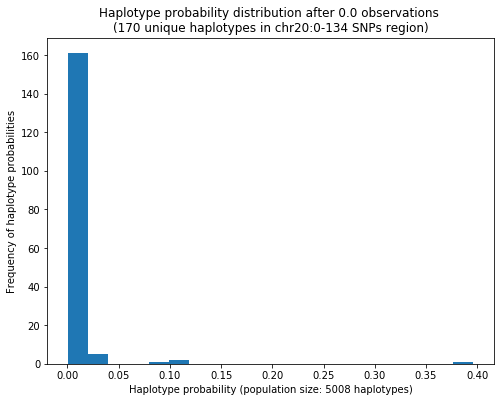

In [36]:
hb.plot()

In [37]:
print hb.map_haplotype()[0]
print hb.map_value()

Hap_20:0-134_00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
0.396365814696


# TODO
- manage haplotype block
  - partition bim file
- inference